In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import Mask,ModelData,VoxelModelCache
from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
from mcmodels.utils import nonzero_unique, unionize
from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_regionalized_normalized_data
from mcmodels.core.utils import get_connectivity
from mcmodels.core.utils import get_ontological_order_leaf
from mcmodels.core.utils import get_nw_loocv,get_wt_inds
from mcmodels.core.utils import get_countvec

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [3]:
#load data
msvds = {}
#gammas = np.asarray([0.1])
for sid in major_structure_ids:
    print(sid)
    voxel_data = ModelData(cache, sid)
    print(cre)
    experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
    experiment_ids = np.asarray(list(experiment_ids))    
    msvd = get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre)
    #msvd.l2losses, msvd.paperlosses,msvd.normspredict,msvd.normtrue = single_region_cv(msvd, gammas)
    msvds[sid]  = msvd
    


512
None
703
None
1089
None
1097
None
315
None
313
None
354
None
698
None
771
None
803
None
477
None
549
None


In [7]:
key = list(msvd.experiments.keys())[0]


In [9]:
contra_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
#get average intensities of projection structures given ipsi and contra keys
source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument


In [11]:
creline = get_cre_status(data_info, msvds)
experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)
leavves = get_leaves_ontologicalorder(msvd, ontological_order)

#contra_key = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=leavves, hemisphere_id=1)
#ipsi_key = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=leavves, hemisphere_id=2)

#msvds = get_regionalized_normalized_data(msvds,cache,ipsi_key,contra_key,experiments_minor_structures)
msvds = get_regionalized_normalized_data(msvds,cache, source_key,ipsi_targetkey,contra_targetkey)

gammas = np.asarray([0.1,.5,1,2,10])
wt_2ormore = get_wt_inds(creline)

for sid in major_structure_ids:
    #print(msvds[sid].projections.shape[0], len(wt_2ormore[sid]))
    msvds[sid].loocv_predictions_all = get_nw_loocv(msvds[sid], np.asarray(list(range(msvds[sid].projections.shape[0]))), get_loocv_predictions, gammas)
    msvds[sid].loocv_predictions_wt = get_nw_loocv(msvds[sid], wt_2ormore[sid], get_loocv_predictions, gammas)

homo_loocv_predictions_all = {}
homo_loocv_predictions_wt = {}
homo_reg_proj_vcount_norm_renorms= {}
for sid in major_structure_ids:
    homo_loocv_predictions_all[sid ] = msvds[sid].loocv_predictions_all
    homo_loocv_predictions_wt[sid ] = msvds[sid].loocv_predictions_wt
    homo_reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm
    
inds_good = {}
for sid in major_structure_ids:
    inds_good[sid] = np.asarray(list(range(msvds[sid].injections.shape[0])))
    
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

#sel_ga_wt = get_best_hyperparameters(losses_wts,keys)

losses_all = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_all,pred_ind = inds_good, true_ind = inds_good,keys = keys)
losses_wts = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_wt,pred_ind = wt_2ormore, true_ind = wt_2ormore, keys = keys)
losses_allwts = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_all,pred_ind = wt_2ormore, true_ind = wt_2ormore, keys = keys)

sel_ga_all = get_best_hyperparameters(losses_all,keys)
sel_ga_allwt = sel_ga_all#get_gamma(losses_allwt,keys)

mean_nw_all = get_loss_best_hyp(losses_all, sel_ga_all)
mean_nw_allwt = get_loss_best_hyp(losses_allwts, sel_ga_all)
#mean_nw_wt = get_loss_best_hyp(losses_all, sel_ga_wt)

print(mean_nw_all)
print(mean_nw_allwt)

losses = np.asarray([mean_nw_all, 
           mean_nw_allwt]).transpose()
losses2 = losses[[4,7,2,1,10,9,11,3,5,8,6,0]]
loss =pd.DataFrame(losses2, columns = ['all','allwt'])

name = 'leafleaf_nw_0720'
expfolder = workingdirectory +   '/data/' + name
loss.to_csv(expfolder + 'losses')

#msvds_save = {}
# for sid in major_structure_ids:
#     np.save(expfolder +'/'+ str(sid) + 'reg_proj_vcount_norm_renorm',msvds[sid].reg_proj_vcount_norm_renorm)
#     np.save(expfolder +'/'+ str(sid) + 'loocv_predictions_all',msvds[sid].loocv_predictions_all)
#     np.save(expfolder +'/'+ str(sid) + 'loocv_predictions_wt',msvds[sid].loocv_predictions_wt)
    
# with open(expfolder +'/'+ 'wt_2ormore_base.pickle', 'wb') as handle:
#     pickle.dump(wt_2ormore, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
ontological_order_leaf = get_ontological_order_leaf(leafs, ontological_order, st)
source_exp_countvec, source_exp_countvec_wt = get_countvec(ontological_order_leaf, ia_map, creline, experiments_minor_structures)
hyperparameters = gammas[sel_ga_all]
df = get_connectivity(msvds, cache, ia_map, hyperparameters, ontological_order_leaf, leavves, leafs, creline,experiments_minor_structures, ipsi_key, contra_key)

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


0
1
2
3
4
5
6
7
8
9
10
11
[0.90097783 0.77737892 0.35946378 0.29377341 0.43029092 0.47135974
 0.40976477 0.44626504 0.45657043 0.53027727 0.69085557 0.42870434]
[1.20922247        nan 0.26124218 0.26865134 0.28385839 0.26417285
 0.39617524 0.2177794  0.57632538 0.50071204 0.48259818 0.34852249]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
42
43
44
45
46
48
49
51
53
54
56
57
60
61
62
63
64
65
66
69
70
72
73
74
76
77
78
84
86
87
88
89
91
92
93
94
96
97
98
100
102
106
107
108
109
112
113
116
117
118
119
120
122
123
124
126
127
129
130
132
134
135
136
138
141
144
145
151
154
157
158
160
162
163
165
166
167
168
169
172
174
175
176
177
178
183
184
186
187
188
189
192
196
197
204
206
209
210
212
213
216
217
218
221
222
223
225
226
227
230
232
233
235
237
239
240
242
243
246
247
249
250
253
257
260
265
266
269
273
275
276
279
281
282
283
284
286
288
289
290


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:263: RuntimeWarning: Mean of empty slice
  output[m] = np.nanmean(losses[sid][hyps[m], :])


0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:120: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


1
2
3


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:120: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


4


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:120: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


5


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:120: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


6
7


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:120: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


8


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:120: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


0


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:120: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


1


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:120: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


2
3
4


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:120: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


5


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:120: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


6
7
8
9
10
11


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:120: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


12
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


IndexError: index 815 is out of bounds for axis 1 with size 577

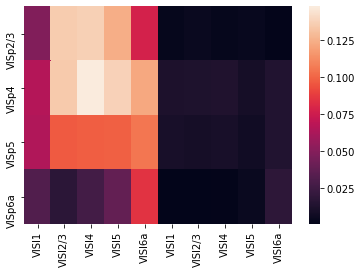

In [57]:
rownames = np.asarray(df.index, dtype = 'str')
colnames = np.asarray(df.columns, dtype = 'str')

firstfour_row = np.asarray([name[:4] for name in rownames])
firstfour_col = np.asarray([name[:4] for name in colnames])

bs = np.where(np.isin(firstfour_row , ['VISp', 'VISl']))[0][4:8]
cs =  np.where(np.isin(firstfour_col , ['VISp', 'VISl']))[0][[0,1,2,3,4,36,37,38,39,40]]

res_ram = df.iloc[bs,cs]
sns.heatmap(res_ram)
plt.savefig(expfolder + '/visp_visl')
res_ram.to_csv(expfolder + '/visp_visl.csv')

In [58]:
df.to_csv(expfolder + '/full_connectivity.csv')

In [7]:
#key = list(msvd.experiments.keys())[0]
# contra_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
# ipsi_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

# def get_regionalized_normalized_data(msvds,ipsi_key,contra_key,experiments_minor_structures):
    
#     major_structure_ids = np.asarray(list(msvds.keys()))
#     for sid in major_structure_ids:
#         #print()
#         msvd = msvds[sid]
#         nexp = msvd.projections.shape[0]

#         minor_structures = np.unique(experiments_minor_structures[sid])
#         nmins = len(minor_structures)

#         projections = msvd.projections
#         ipsi_proj = unionize(projections, ipsi_key)
#         contra_proj = unionize(projections, contra_key)
#         reg_proj = np.hstack([ipsi_proj, contra_proj])
#         msvd.reg_proj = reg_proj

#         ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_key, return_counts=True)
#         contra_target_regions, contra_target_counts = nonzero_unique(contra_key, return_counts=True)
#         target_counts = np.concatenate([ipsi_target_counts, contra_target_counts])
#         reg_proj_vcount_norm = np.divide(reg_proj, target_counts[np.newaxis, :])
#         msvd.reg_proj_vcount_norm = reg_proj_vcount_norm

#         projections = msvds[sid].reg_proj_vcount_norm
#         projections = projections / np.expand_dims(np.linalg.norm(projections, axis = 1),1)
#         msvd.reg_proj_vcount_norm_renorm = projections

#         source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
#         source_key = source_mask.get_key(structure_ids=ontological_order)  
#         source_target_counts, source_target_counts =nonzero_unique(source_key, return_counts=True)

#         injections = msvd.injections
#         reg_ipsi_inj = unionize(injections, source_key)
#         msvd.reg_inj = reg_ipsi_inj  
#         reg_inj_vcount_norm = np.divide(reg_ipsi_inj, source_target_counts[np.newaxis, :])
#         msvd.reg_inj_vcount_norm = reg_inj_vcount_norm
#     return(msvds)



In [16]:
# def get_wt_inds(creline):
    
#     major_structure_ids = np.asarray(list(creline.keys()))
#     wt_2ormore = {}
#     for sid in major_structure_ids:
#         wt_inds = np.where(creline[sid] == 'C57BL/6J')[0]
#         wt_2ormore[sid] = np.asarray([])
#         if len(wt_inds) > 1:
#             wt_2ormore[sid] = np.append(wt_2ormore[sid],wt_inds)
#         wt_2ormore[sid] = np.asarray(wt_2ormore[sid], dtype = int)
#     return(wt_2ormore)
    

# def get_nw_loocv(msvd, indices,loocv, hyperparameters):
    
#     #major_structure_ids = np.asarray(list(creline.keys()))

#     if len(indices) > 1:
#         projections = msvd.reg_proj_vcount_norm_renorm
#         centroids = msvd.centroids
#         nreg = projections.shape[1]
#         nexp = projections.shape[0]
#         nhyp = hyperparameters.shape[0]
#         loocv_predictions = np.zeros((nhyp, nexp, nreg))
#         for g in range(nhyp):
#             loocv_predictions[g,indices] = loocv(projections[indices], centroids[indices], hyperparameters[g])
#         return(loocv_predictions)
#     else:
#         return(np.asarray([]))
    
# def get_countvec(ontological_order, ia_map, creline, experiments_minor_structures):
#     major_structure_ids = np.asarray(list(creline.keys()))
#     sourcenames = np.asarray([ia_map[ontological_order[i]] for i in range(len(ontological_order))])
#     source_exp_counts = {}
#     source_exp_counts_wt = {}
#     for i in range(len(sourcenames)):
#         source_exp_counts[sourcenames[i]] = 0
#         source_exp_counts_wt[sourcenames[i]] = 0
#         for sid in major_structure_ids:
#             source_exp_counts[sourcenames[i]] += len(np.where(experiments_minor_structures[sid] == sourcenames[i])[0])
#             source_exp_counts_wt[sourcenames[i]] += len(np.intersect1d(np.where(experiments_minor_structures[sid] == sourcenames[i])[0],
#                                                                        np.where(creline[sid] == 'C57BL/6J')))
#     source_exp_countvec = np.asarray(list(source_exp_counts.values()))
#     source_exp_countvec_wt= np.asarray(list(source_exp_counts_wt.values()))
#     return(source_exp_countvec, source_exp_countvec_wt)

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


In [12]:
# nms = len(major_structure_ids)
# ngam = len(gammas)
# wt_2ormore = {}
# losses_reg_norm = np.zeros((nms,ngam))
# for m in range(12):
#     sid = major_structure_ids[m]

#     centroids = msvds[sid].centroids
#     nreg = projections.shape[1]
#     nexp = projections.shape[0]
#     nfeat = projections.shape[1]
#     msvds[sid].loocv_predictions_wt = np.zeros((ngam, nexp, nreg))
#     msvds[sid].loocv_predictions_all = np.zeros((ngam, nexp, nreg))
#     wt_inds = np.where(creline[sid] == 'C57BL/6J')[0]
#     wt_2ormore[sid] = np.asarray([])
#     for g in range(ngam):
#         print(g,'g')
#         msvds[sid].loocv_predictions_all[g] = get_loocv_predictions(projections, centroids, gammas[g])
#         if len(wt_inds) > 1:
#             msvds[sid].loocv_predictions_wt[g, wt_inds] = get_loocv_predictions(projections[wt_inds], centroids[wt_inds], gammas[g])
#             if g == 0:
#                 wt_2ormore[sid] = np.append(wt_2ormore[sid],wt_inds)
#     wt_2ormore[sid] = np.asarray(wt_2ormore[sid], dtype = int)

[0.91745875 0.88343212 0.37942834 0.30860234 0.40127128 0.48650491
 0.4394712  0.53795851 0.52413763 0.56407093 0.73076523 0.49477931]
[1.24012776        nan 0.2856898  0.27171249 0.28668256 0.30083321
 0.4050365  0.27780347 0.47436776 0.51718867 0.48992362 0.47461583]


In [36]:

#os.mkdir(expfolder)

In [40]:
# leafs = {}
# for sid in major_structure_ids:
#     print(sid)
#     msvd = msvds[sid]
    
#     leafs[sid] = get_leaf_structure(msvd, experiments_minor_structures[sid])

# with open('leafs.pickle', 'wb') as handle:
#     pickle.dump(leafs, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [41]:

 
# def get_ontological_order_leaf(leafs, ontological_order, st):
    
#     major_structure_ids = np.asarray(list(leafs.keys()))
#     leaf_present = np.concatenate([leafs[sid] for sid in major_structure_ids])
#     ontological_order_leaf = np.asarray([])
#     for i in range(len(ontological_order)):
#         #which of these are in leafs
#         stos = np.asarray(st.child_ids([ontological_order[i]]))
#         which_stos = np.asarray(np.where(np.isin(stos, leaf_present)[0])[0], dtype = int)
#         if len(which_stos) > 0:
#             print(i)
#             ontological_order_leaf = np.append(ontological_order_leaf, stos[0][which_stos])
#         if np.isin(ontological_order[i], leaf_present):
#             print(i)
#             ontological_order_leaf = np.append(ontological_order_leaf, ontological_order[i])
#     ontological_order_leaf = np.asarray(ontological_order_leaf, dtype = int)
#     return(ontological_order_leaf)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
42
43
44
45
46
48
49
51
53
54
56
57
60
61
62
63
64
65
66
69
70
72
73
74
76
77
78
84
86
87
88
89
91
92
93
94
96
97
98
100
102
106
107
108
109
112
113
116
117
118
119
120
122
123
124
126
127
129
130
132
134
135
136
138
141
144
145
151
154
157
158
160
162
163
165
166
167
168
169
172
174
175
176
177
178
183
184
186
187
188
189
192
196
197
204
206
209
210
212
213
216
217
218
221
222
223
225
226
227
230
232
233
235
237
239
240
242
243
246
247
249
250
253
257
260
265
266
269
273
275
276
279
281
282
283
284
286
288
289
290


In [27]:
# hyperparameters = gammas[sel_ga_all]
# ordering = leavves

In [36]:
#from sklearn.metrics.pairwise import pairwise_kernels

# def get_connectivity(msvds, hyperparameters, ordering, creline,experiments_minor_structures):
    
#     source_exp_countvec, source_exp_countvec_wt = get_countvec(ontological_order_leaf, ia_map, creline, experiments_minor_structures)
    
#     major_structure_ids = np.asarray(list(msvds.keys()))
#     nms = len(major_structure_ids)
#     prediction_union_norms = {}
#     source_region_save= np.asarray([])
    
#     for m in range(nms):
#         gamma = hyperparameters[m]
#         sid = major_structure_ids[m]
#         injection_mask = Mask.from_cache(
#             cache,
#             structure_ids=[major_structure_ids[m]],
#             hemisphere_id=2)    
#         weights = pairwise_kernels(X = msvds[sid].centroids, Y = injection_mask.coordinates, metric = 'rbf', gamma = gamma, filter_params=True)
#         weights = weights / weights.sum(axis = 0)
#         weights[np.where(np.isnan(weights))] = 0.
#         predictions = np.dot(weights.transpose(), msvds[sid].reg_proj_vcount_norm_renorm)
#         union_key = injection_mask.get_key(structure_ids=ordering, hemisphere_id=2)
#         #print(np.unique(union_key))
#         source_regions, source_counts = nonzero_unique(union_key, return_counts=True)
#         prediction_union = unionize(predictions.transpose(), union_key)
#         prediction_union_norms[m] = prediction_union.transpose() / np.expand_dims(source_counts,1)
#         source_region_save = np.append(source_region_save, source_regions)    
        
#     order = lambda x: np.array(ordering)[np.isin(ordering, x)]
#     permutation = lambda x: np.argsort(np.argsort(order(x)))
#     ords = np.concatenate([permutation(ipsi_target_regions), len(ipsi_target_regions) + permutation(contra_target_regions)])
#     ordssource = source_region_save.argsort()[permutation(source_region_save[source_region_save.argsort()])]
#     cd = np.vstack([prediction_union_norms[m] for m in range(len(prediction_union_norms.keys()))])
    
#     #get row names
#     rownames = [ia_map[ordering[i]] for i in range(len(ordering))]
#     rownames = np.asarray(rownames)[np.where(source_exp_countvec !=0)[0]]
    
#     #get column names
#     targes = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)], contra_target_regions[permutation(contra_target_regions)]])
#     colnames = np.asarray([ia_map[targes[i]] for i in range(len(targes))])
    
#     df = pd.DataFrame(cd[:,ords][ordssource], index = rownames, columns = colnames)
#     return(df)

In [45]:

#ordering = leavves
#source_ordering = ontological_order_leaf
#target_ordering = leavves

In [85]:


# target_order = lambda x: np.array(target_ordering)[np.isin(target_ordering, x)]
# permutation = lambda x: np.argsort(np.argsort(target_order(x)))
# targ_ords = np.concatenate([permutation(ipsi_target_regions), 541 + permutation(contra_target_regions)])


In [32]:
# a = 0
# nms = 12
# for m in range(nms):
#     sid = major_structure_ids[m]
#     print(len(np.unique(leafs[sid])))
#     print(len(ontological_order_leaf[np.where(np.isin(ontological_order_leaf, np.unique(leafs[sid])))]))
#     a += len(ontological_order_leaf[np.where(np.isin(ontological_order_leaf, np.unique(leafs[sid])))])

13
13
5
5
18
16
21
21
119
119
23
23
19
19
9
9
13
13
7
7
8
8
29
28


0


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights[np.where(np.isnan(weights))] = 0.


1


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights[np.where(np.isnan(weights))] = 0.


2


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights[np.where(np.isnan(weights))] = 0.


3


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights[np.where(np.isnan(weights))] = 0.


4


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights[np.where(np.isnan(weights))] = 0.


5


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights[np.where(np.isnan(weights))] = 0.


6


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights[np.where(np.isnan(weights))] = 0.


7


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights[np.where(np.isnan(weights))] = 0.


8


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights[np.where(np.isnan(weights))] = 0.


9


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights[np.where(np.isnan(weights))] = 0.


10
11
12
0
1
2
3
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights[np.where(np.isnan(weights))] = 0.


1
2
3


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights[np.where(np.isnan(weights))] = 0.


4


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights[np.where(np.isnan(weights))] = 0.


5


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights[np.where(np.isnan(weights))] = 0.


6
7


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights[np.where(np.isnan(weights))] = 0.


8


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights[np.where(np.isnan(weights))] = 0.


0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [118]:
# def get_connectivity(msvds, hyperparameters, source_ordering, target_ordering , leafs, creline,experiments_minor_structures):
    
#     source_exp_countvec, source_exp_countvec_wt = get_countvec(source_ordering, ia_map, creline, experiments_minor_structures)
    
#     major_structure_ids = np.asarray(list(msvds.keys()))
#     nms = len(major_structure_ids)
#     prediction_union_norms = {}
#     source_region_save= np.asarray([])
    
#     for m in range(nms):
#         sid = major_structure_ids[m]
#         gamma = hyperparameters[m]
#         minor_structures = source_ordering[np.where(np.isin(source_ordering, np.unique(leafs[sid])))]
#         #ontological_order_leaf np.unique(leafs[sid]) # this should be in ontological order # np.unique(leafs[sid])#source_ordering[sid]#
#         prediction_union_norms[m] = {}
#         for n in range(len(minor_structures)):
#             print(n)
#             minor_structure_inds = np.where(leafs[sid] == minor_structures[n])[0]
#             #meezy = minor_structures[n]
#             im = Mask.from_cache(
#                     cache,
#                     structure_ids=[minor_structures[n]],
#                     hemisphere_id=2)
#             weights = pairwise_kernels(X = msvds[sid].centroids[minor_structure_inds], Y = im.coordinates, metric = 'rbf', gamma = gamma, filter_params=True)
#             weights = weights / weights.sum(axis = 0)
#             weights[np.where(np.isnan(weights))] = 0.
#             predictions = np.dot(weights.transpose(), msvds[sid].reg_proj_vcount_norm_renorm[minor_structure_inds])
            
#             #average over source region voxels
#             union_key = im.get_key(structure_ids=source_ordering, hemisphere_id=2)
#             source_regions, source_counts = nonzero_unique(union_key, return_counts=True)
#             prediction_union = unionize(predictions.transpose(), union_key)
#             prediction_union_norms[m][n] = prediction_union.transpose() / np.expand_dims(source_counts,1)
#             source_region_save = np.append(source_region_save, source_regions)

#     prediction_union_norms_ms = {}
#     for m in range(nms):
#         prediction_union_norms_ms[m] = np.vstack([prediction_union_norms[m][n] for n in range(len(prediction_union_norms[m].keys()))])

#     cd = np.vstack([prediction_union_norms_ms[m] for m in range(len(prediction_union_norms_ms.keys()))])
    
#     #get row names
#     rownames = [ia_map[source_ordering[i]] for i in range(len(source_ordering))]
#     #rownames = np.asarray(rownames)[np.where(source_exp_countvec !=0)[0]]
    
#     #get column names
#     ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_key, return_counts=True)
#     contra_target_regions, contra_target_counts = nonzero_unique(contra_key, return_counts=True)
#     target_order = lambda x: np.array(target_ordering)[np.isin(target_ordering, x)]
#     permutation = lambda x: np.argsort(np.argsort(target_order(x)))    
#     targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)], contra_target_regions[permutation(contra_target_regions)]])
#     colnames = np.asarray([ia_map[targ_ids[i]] for i in range(len(targ_ids))])

#     #reorder rows and columns
#     targ_ords = np.concatenate([permutation(ipsi_target_regions), len(ipsi_target_regions) + permutation(contra_target_regions)])
#     row_reorder = np.asarray([])
#     source_region_save = np.asarray(source_region_save, dtype =int)
#     for i in range(len(source_ordering)):
#         inx = np.where(source_region_save == int(source_ordering[i]))[0]
#         if len(inx)>0:
#             row_reorder = np.append(row_reorder, inx)
#     row_reorder = np.asarray(row_reorder, dtype = int)
    
#     df = pd.DataFrame(cd[row_reorder][:,targ_ords],index = rownames, columns = np.asarray(colnames))
#     return(df)

In [104]:
#df = pd.DataFrame(cd[row_reorder][:,targ_ords],index = rownames, columns = np.asarray(colnames))

In [4]:
fig, ax = plt.subplots(0,figsize = (50,50))
sns.heatmap(df, vmax = 0.1, vmin=0.)

NameError: name 'df' is not defined

<Figure size 3600x3600 with 0 Axes>

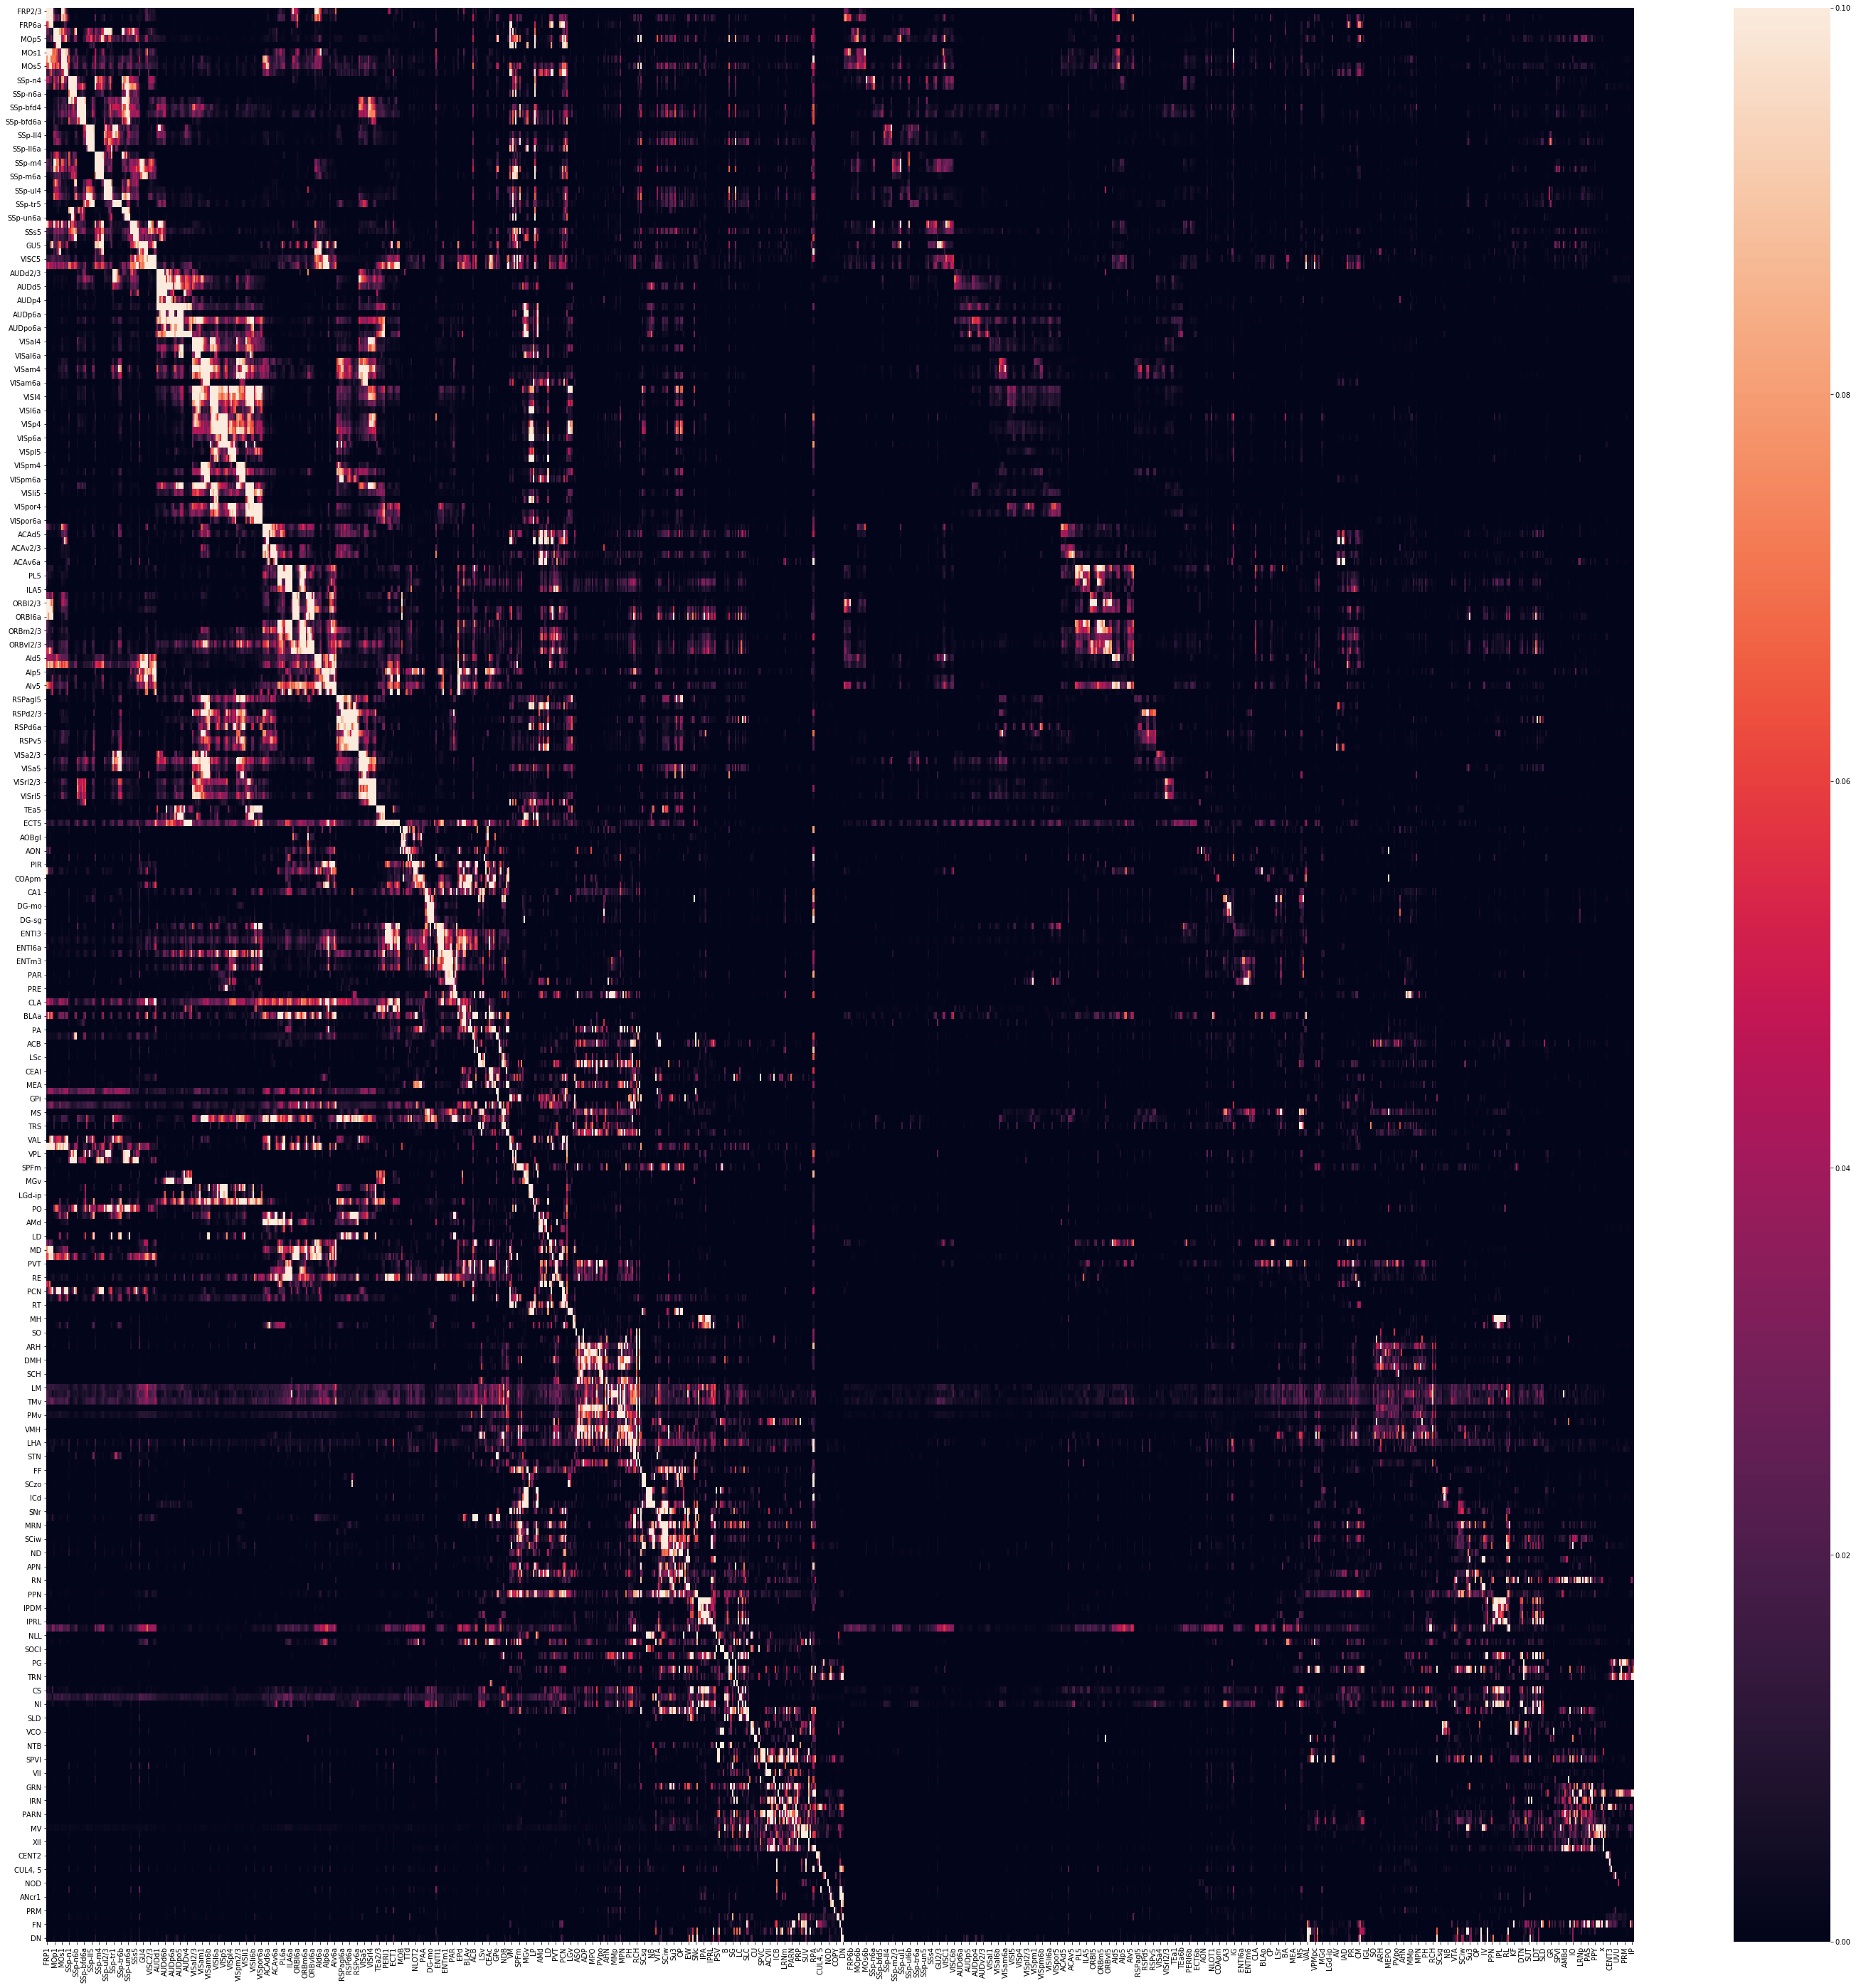

In [51]:
fig, ax = plt.subplots(0,figsize = (50,50))
sns.heatmap(df, vmax = 0.1, vmin=0.)

In [63]:
gammas_selected_cv = gammas[sel_ga_all]
prediction_union_norms = {}
source_region_save= np.asarray([])
for m in range(nms):
    gamma = gammas_selected_cv[m]
    sid = major_structure_ids[m]
    injection_mask = Mask.from_cache(
        cache,
        structure_ids=[major_structure_ids[m]],
        hemisphere_id=2)
    minor_structures = np.unique(leafs[sid])
    prediction_union_norms[m] = {}
    for n in range(len(minor_structures)):
        
        minor_structure_inds = np.where(leafs[sid] == minor_structures[n])[0]
        #meezy = minor_structures[n]
        im = Mask.from_cache(
                cache,
                structure_ids=[minor_structures[n]],
                hemisphere_id=2)
        weights = pairwise_kernels(X = msvds[sid].centroids[minor_structure_inds], Y = im.coordinates, metric = 'rbf', gamma = gamma, filter_params=True)
        weights = weights / weights.sum(axis = 0)
        weights[np.where(np.isnan(weights))] = 0.
        predictions = np.dot(weights.transpose(), msvds[sid].reg_proj_vcount_norm_renorm[minor_structure_inds])
        union_key = im.get_key(structure_ids=ontological_order_leaf, hemisphere_id=2)
        #print(np.unique(union_key))
        source_regions, source_counts = nonzero_unique(union_key, return_counts=True)
        prediction_union = unionize(predictions.transpose(), union_key)
        prediction_union_norms[m][n] = prediction_union.transpose() / np.expand_dims(source_counts,1)
        source_region_save = np.append(source_region_save, source_regions)
        #find centroids in that region

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs

In [49]:
prediction_union_norms_old = prediction_union_norms.copy()

In [52]:
minor_structures[0]

15

In [57]:
prediction_union_norms_old[11][0].max()

0.7309579471659695

In [64]:
#np.where((source_region_save == 184))[0]
ordering=leavves
order = lambda x: np.array(ordering)[np.isin(ordering, x)]
permutation = lambda x: np.argsort(np.argsort(order(x)))

ords = np.concatenate([permutation(ipsi_target_regions), 541 + permutation(contra_target_regions)])
targes = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)], contra_target_regions[permutation(contra_target_regions)]])

#np.where((source_region_save == 184))[0]
ordering=ontological_order_leaf
order = lambda x: np.array(ordering)[np.isin(ordering, x)]
permutation = lambda x: np.argsort(np.argsort(order(x)))

ordssource = source_region_save.argsort()[permutation(source_region_save[source_region_save.argsort()])]
#need to stack minor structures
prediction_union_norms_ms = {}
for m in range(nms):
    prediction_union_norms_ms[m] = np.vstack([prediction_union_norms[m][n] for n in range(len(prediction_union_norms[m].keys()))])
cd = np.vstack([prediction_union_norms_ms[m] for m in range(len(prediction_union_norms_ms.keys()))])
#cd[np.abs(cd) < 0.000001] = 0


In [65]:
prediction_union_norms_ms[m].max()

0.9547791401145745

In [66]:
cd.max()

0.9844982448093292

In [44]:
reorder = np.asarray([])
source_region_save = np.asarray(source_region_save, dtype =int)
ontological_order_leaf = np.asarray(ontological_order_leaf, dtype = int)
for i in range(len(ontological_order_leaf)):
    inx = np.where(source_region_save == int(ontological_order_leaf[i]))[0]
    if len(inx)>0:
        reorder = np.append(reorder, inx)
reorder = np.asarray(reorder, dtype = int)

In [45]:

sourcenames = np.asarray(ontological_order_leaf)
source_exp_counts = {}
source_exp_counts_wt = {}
for i in range(len(sourcenames)):
    source_exp_counts[sourcenames[i]] = 0
    source_exp_counts_wt[sourcenames[i]] = 0
    for sid in major_structure_ids:
        source_exp_counts[sourcenames[i]] += len(np.where(leafs[sid] == sourcenames[i])[0])
        source_exp_counts_wt[sourcenames[i]] += len(np.intersect1d(np.where(leafs[sid] == sourcenames[i])[0],
                                                                   np.where(creline[sid] == 'C57BL/6J')))
source_exp_countvec = np.asarray(list(source_exp_counts.values()))
source_exp_countvec_wt= np.asarray(list(source_exp_counts_wt.values()))

rownames = [ia_map[ontological_order_leaf[i]] for i in range(len(ontological_order_leaf))]
colnames = np.asarray([ia_map[targes[i]] for i in range(len(targes))])
rownames = np.asarray(rownames)[np.where(source_exp_countvec !=0)[0]]


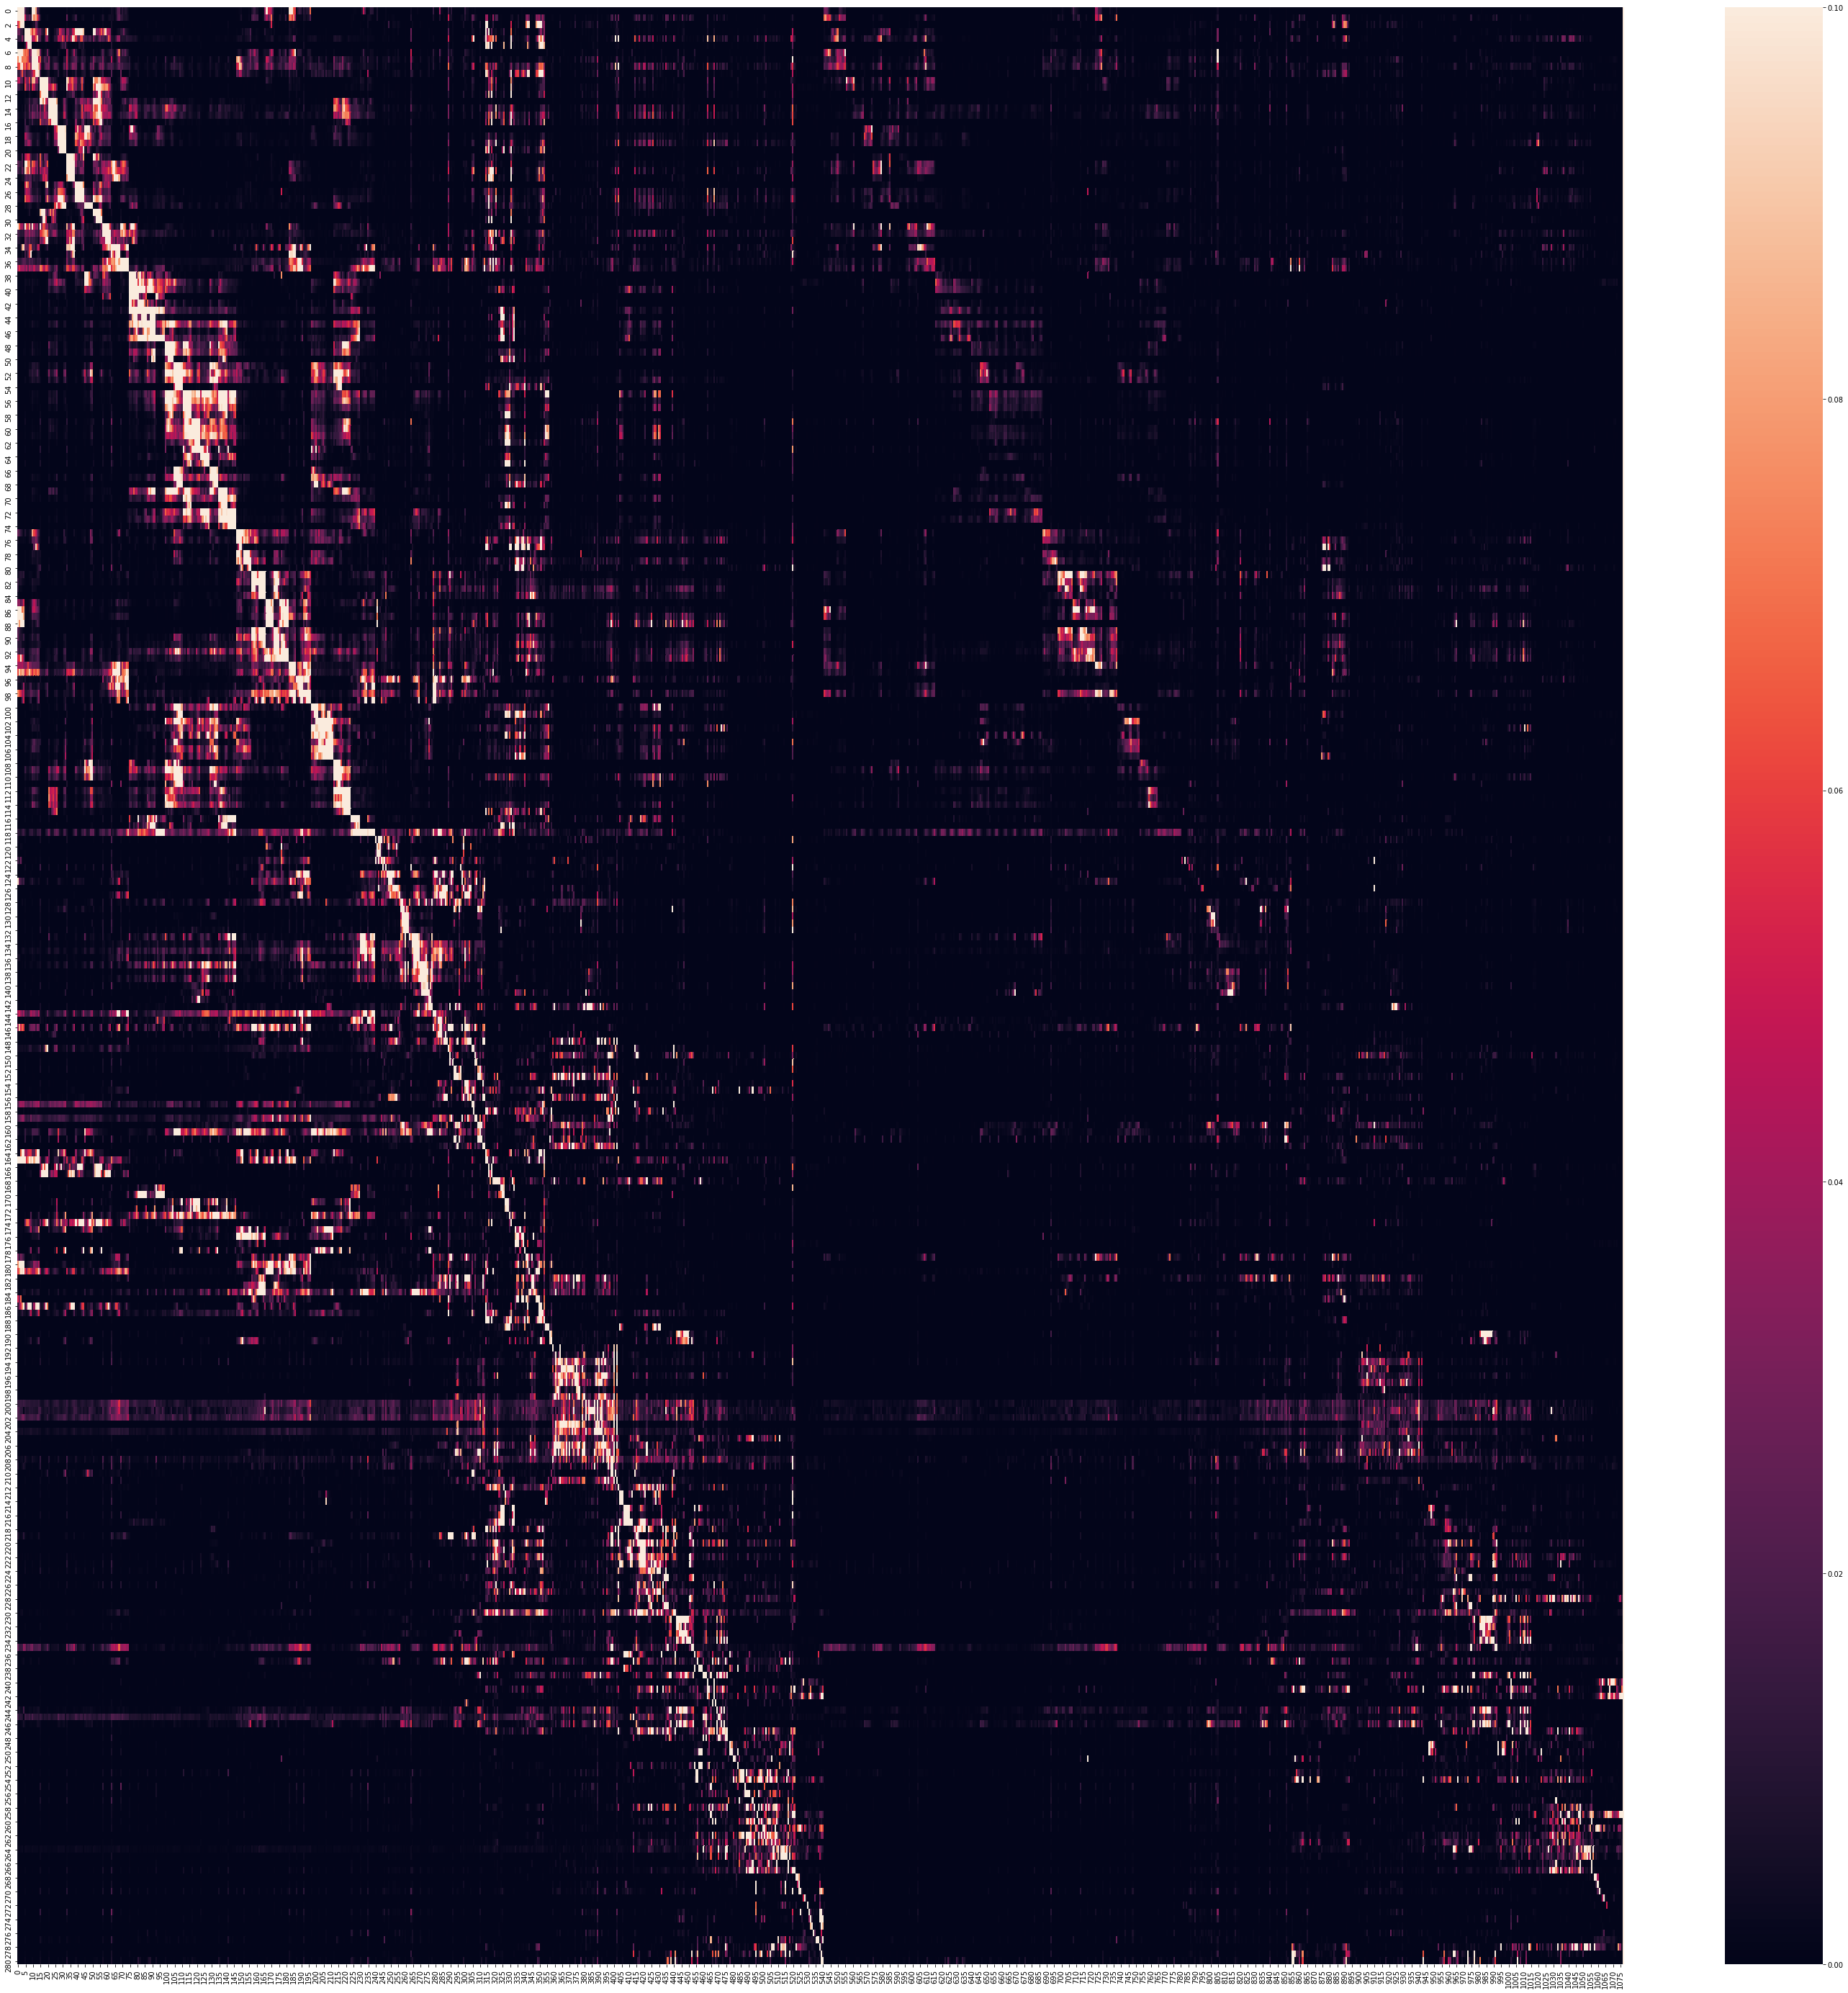

In [48]:
source_exp_countvec = source_exp_countvec[np.where(source_exp_countvec !=0)[0]]
#source_exp_countvec_wt = source_exp_countvec_wt[np.where(source_exp_countvec_wt !=0)[0]]
colnames = np.append(colnames, '# exp')
df_all = pd.DataFrame(np.hstack([cd[:,ords][reorder],np.expand_dims(source_exp_countvec,1)]))
fig, ax = plt.subplots(0,figsize = (50,50))
sns.heatmap(df_all, vmax = 0.1, vmin=0.)#, ax=ax)
# plt.savefig('leaves_all2')
# df_all.to_csv('leaves_all2.csv')

In [69]:
np.asarray(df_all)[:,:-2].max()

0.9844982448093292

In [216]:
colnames[:-2].shape

(1078,)

In [212]:
colnames.shape

(1079,)

In [47]:
import matplotlib.pyplot as plt

In [157]:
#leavves v ontological_order_leaf
#leavves is the leaves associated with ontological_order
#ontological_order_leaf is the leaves that are actually present
#leafs is the dictionary with the leaves of the experiments

(291, 1077)

In [52]:
len(ontological_order)

291

In [150]:
# leafs = {}
# for sid in major_structure_ids:
#     print(sid)
#     msvd = msvds[sid]
    
#     leafs[sid] = get_leaf_structure(msvd, experiments_minor_structures[sid])

# with open('leafs.pickle', 'wb') as handle:
#     pickle.dump(leafs, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
leaf_present = np.concatenate([leafs[sid] for sid in major_structure_ids])
ontological_order_leaf = np.asarray([])
for i in range(len(ontological_order)):
    #which of these are in leafs
    stos = np.asarray(st.child_ids([ontological_order[i]]))
    which_stos = np.asarray(np.where(np.isin(stos, leaf_present)[0])[0], dtype = int)
    if len(which_stos) > 0:
        print(i)
        ontological_order_leaf = np.append(ontological_order_leaf, stos[0][which_stos])
    if np.isin(ontological_order[i], leaf_present):
        print(i)
        ontological_order_leaf = np.append(ontological_order_leaf, ontological_order[i])
ontological_order_leaf = np.asarray(ontological_order_leaf, dtype = int)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
42
43
44
45
46
48
49
51
53
54
56
57
60
61
62
63
64
65
66
69
70
72
73
74
76
77
78
84
86
87
88
89
91
92
93
94
96
97
98
100
102
106
107
108
109
112
113
116
117
118
119
120
122
123
124
126
127
129
130
132
134
135
136
138
141
144
145
151
154
157
158
160
162
163
165
166
167
168
169
172
174
175
176
177
178
183
184
186
187
188
189
192
196
197
204
206
209
210
212
213
216
217
218
221
222
223
225
226
227
230
232
233
235
237
239
240
242
243
246
247
249
250
253
257
260
265
266
269
273
275
276
279
281
282
283
284
286
288
289
290


In [ ]:
nms = len(major_structure_ids)
ngam = len(gammas)
losses_reg_norm = np.zeros((nms,ngam))
wt_2ormore = {}
for m in range(nms):
    #m= 4
    sid = major_structure_ids[m]
    projections = msvds[sid].reg_proj_vcount_norm
    print(projections.shape)
    centroids = msvds[sid].centroids
    nreg = projections.shape[1]
    nexp = projections.shape[0]
    wt_inds = np.where(creline[sid] == 'C57BL/6J')[0]
    nwtexp = len(wt_inds)
    minor_structures = np.unique(leafs[sid])#np.unique(experiments_minor_structures[sid])
    nmins = len(minor_structures)
    
    projections = projections / np.expand_dims(np.linalg.norm(projections, axis = 1),1)
    msvds[sid].reg_proj_vcount_norm_renorm = projections
    
    msvds[sid].loocv_predictions_all = np.zeros((ngam, nexp, nreg))
    #nexp rather than nwtexp to retain indexing
    msvds[sid].loocv_predictions_wt = np.zeros((ngam, nexp, nreg))
    wt_2ormore[sid] = np.asarray([])
    for n in range(nmins):
        #n = 65
        print(sid,n)
        minor_structure = minor_structures[n]
        mis_inds = np.where(leafs[sid] == minor_structure)[0]#np.where(experiments_minor_structures[sid] == minor_structure)[0]
        wt_mis_inds = np.intersect1d(mis_inds, wt_inds)

        for g in range(ngam):
            #losses_reg_norm[m,g] = get_loss_paper(projections[inds], loocv_predictions[inds])
            msvds[sid].loocv_predictions_all[g,mis_inds] = get_loocv_predictions(projections[mis_inds], centroids[mis_inds], gammas[g])
#             if len(wt_mis_inds) > 1:
#                 if g == 0:
#                     wt_2ormore[sid] = np.append(wt_2ormore[sid],wt_mis_inds)
#                 msvds[sid].loocv_predictions_wt[g,wt_mis_inds] = get_loocv_predictions(projections[wt_mis_inds], centroids[wt_mis_inds], gammas[g])
                
    wt_2ormore[sid] = np.asarray(wt_2ormore[sid], dtype = int)

In [143]:
    major_structure_ids = np.asarray(list(msvds.keys()))
    nms = len(major_structure_ids)
    prediction_union_norms = {}
    source_region_save= np.asarray([])
    
    for m in range(nms):
        gamma = hyperparameters[m]
        sid = major_structure_ids[m]
        injection_mask = Mask.from_cache(
            cache,
            structure_ids=[major_structure_ids[m]],
            hemisphere_id=2)    
        weights = pairwise_kernels(X = msvds[sid].centroids, Y = injection_mask.coordinates, metric = 'rbf', gamma = gamma, filter_params=True)
        weights = weights / weights.sum(axis = 0)
        weights[np.where(np.isnan(weights))] = 0.
        predictions = np.dot(weights.transpose(), msvds[sid].reg_proj_vcount_norm_renorm)
        union_key = injection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
        #print(np.unique(union_key))
        source_regions, source_counts = nonzero_unique(union_key, return_counts=True)
        prediction_union = unionize(predictions.transpose(), union_key)
        prediction_union_norms[m] = prediction_union.transpose() / np.expand_dims(source_counts,1)
        source_region_save = np.append(source_region_save, source_regions)    
        
    order = lambda x: np.array(ordering)[np.isin(ordering, x)]
    permutation = lambda x: np.argsort(np.argsort(order(x)))
    ords = np.concatenate([permutation(ipsi_target_regions), len(ipsi_target_regions) + permutation(contra_target_regions)])
    ordssource = source_region_save.argsort()[permutation(source_region_save[source_region_save.argsort()])]
    cd = np.vstack([prediction_union_norms[m] for m in range(len(prediction_union_norms.keys()))])
    
    rownames = [ia_map[ordering[i]] for i in range(len(ordering))]
    targes = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)], contra_target_regions[permutation(contra_target_regions)]])
    colnames = np.asarray([ia_map[targes[i]] for i in range(len(targes))])
    #colnames = np.append(colnames)
    df = pd.DataFrame(cd[:,ords][ordssource], index = rownames, columns = colnames)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


ValueError: Shape of passed values is (221, 1077), indices imply (541, 1077)

In [144]:
cd[:,ords][ordssource].shape

(221, 1077)

In [134]:
len(permutation(ipsi_target_regions))

221

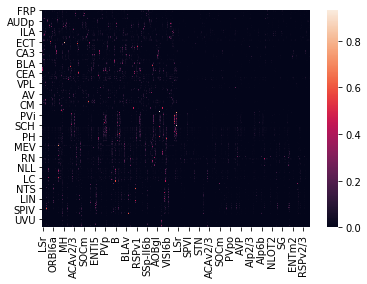

In [122]:
sns.heatmap(df)

In [112]:
gammas[sel_ga_all]

array([10. ,  0.1,  0.1,  0.1,  0.5,  0.5,  0.5, 10. ,  0.1,  0.1,  0.1,
        0.5])

In [110]:
sel_ga_all

array([[4],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [4],
       [0],
       [0],
       [0],
       [1]])

In [98]:
gammas_selected_cv = sel_gamma_voxel_all
prediction_union_norms = {}
source_region_save= np.asarray([])
for m in range(nms):
    gamma = gammas[gammas_selected_cv[m]]
    sid = major_structure_ids[m]
    injection_mask = Mask.from_cache(
        cache,
        structure_ids=[major_structure_ids[m]],
        hemisphere_id=2)    
    weights = pairwise_kernels(X = msvds[sid].centroids, Y = injection_mask.coordinates, metric = 'rbf', gamma = gamma, filter_params=True)
    weights = weights / weights.sum(axis = 0)
    weights[np.where(np.isnan(weights))] = 0.
    predictions = np.dot(weights.transpose(), msvds[sid].reg_proj_vcount_norm_renorm)
    union_key = injection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
    #print(np.unique(union_key))
    source_regions, source_counts = nonzero_unique(union_key, return_counts=True)
    prediction_union = unionize(predictions.transpose(), union_key)
    prediction_union_norms[m] = prediction_union.transpose() / np.expand_dims(source_counts,1)
    source_region_save = np.append(source_region_save, source_regions)

NameError: name 'sel_gamma_voxel_all' is not defined

In [ ]:
ordering=ontological_order
order = lambda x: np.array(ordering)[np.isin(ordering, x)]
permutation = lambda x: np.argsort(np.argsort(order(x)))

ords = np.concatenate([permutation(ipsi_target_regions), 291 + permutation(contra_target_regions)])
ordssource = source_region_save.argsort()[permutation(source_region_save[source_region_save.argsort()])]
cd = np.vstack([prediction_union_norms[m] for m in range(len(prediction_union_norms.keys()))])

In [ ]:
cd[:,ords][ordssource]